<h1>Import frameworks</h1>

In [16]:
import umap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import rand_score
import itertools
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


<h1>Import and preprocessing</h1>

In [17]:
random_state = 79
seeds = pd.read_table('../seeds.tsv')
seeds.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove', 'species']

X = seeds.drop(columns=['species'])  # Features
y = seeds['species']  

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

seeds_normalized = pd.DataFrame(X_normalized, columns=X.columns)
seeds_normalized['species'] = y
print(seeds_normalized.head())


       area  perimeter  compactness    length     width  asymmetry    groove  \
0  0.011840   0.009234     0.427494 -0.166808  0.197647  -1.792787 -0.921971   
1 -0.190940  -0.358353     1.438945 -0.760533  0.208238  -0.672161 -1.188607   
2 -0.345602  -0.473224     1.036904 -0.686035  0.319438  -0.965484 -1.229314   
3  0.444896   0.330872     1.371233  0.067974  0.803955  -1.568128 -0.476222   
4 -0.160007  -0.266457     1.019976 -0.546070  0.142047  -0.830155 -0.921971   

   species  
0        1  
1        1  
2        1  
3        1  
4        1  


<h1>Number of clusters</h1>

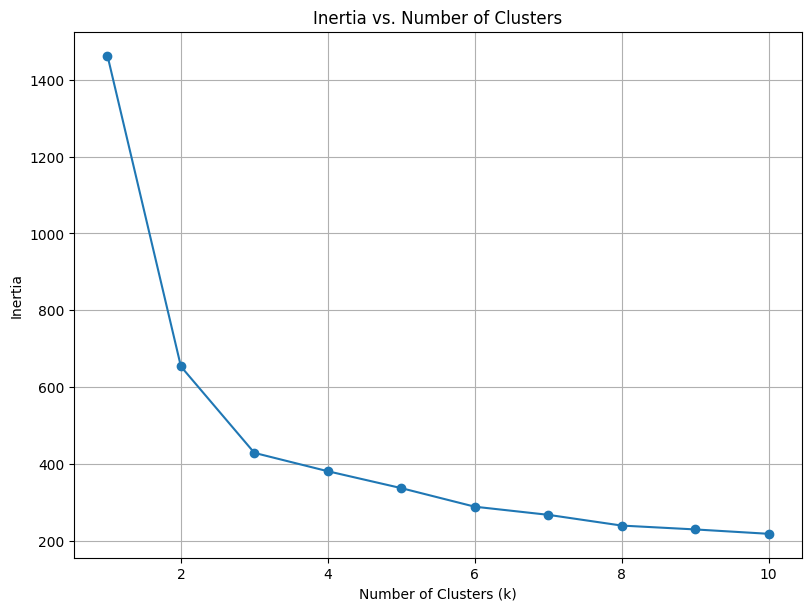

In [23]:
X = seeds_normalized.drop(columns=['species'])

inertia_values = []

for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=random_state).fit(X)
    inertia_values.append(kmeans.inertia_)

fig1, ax1 = plt.subplots(figsize=(8, 6), layout='constrained')
ax1.plot(range(1, 11), inertia_values, marker='o')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Inertia vs. Number of Clusters')
ax1.grid(True)
fig1.savefig("intertia.pdf", bbox_inches='tight')

<h1>Vizualize</h1>

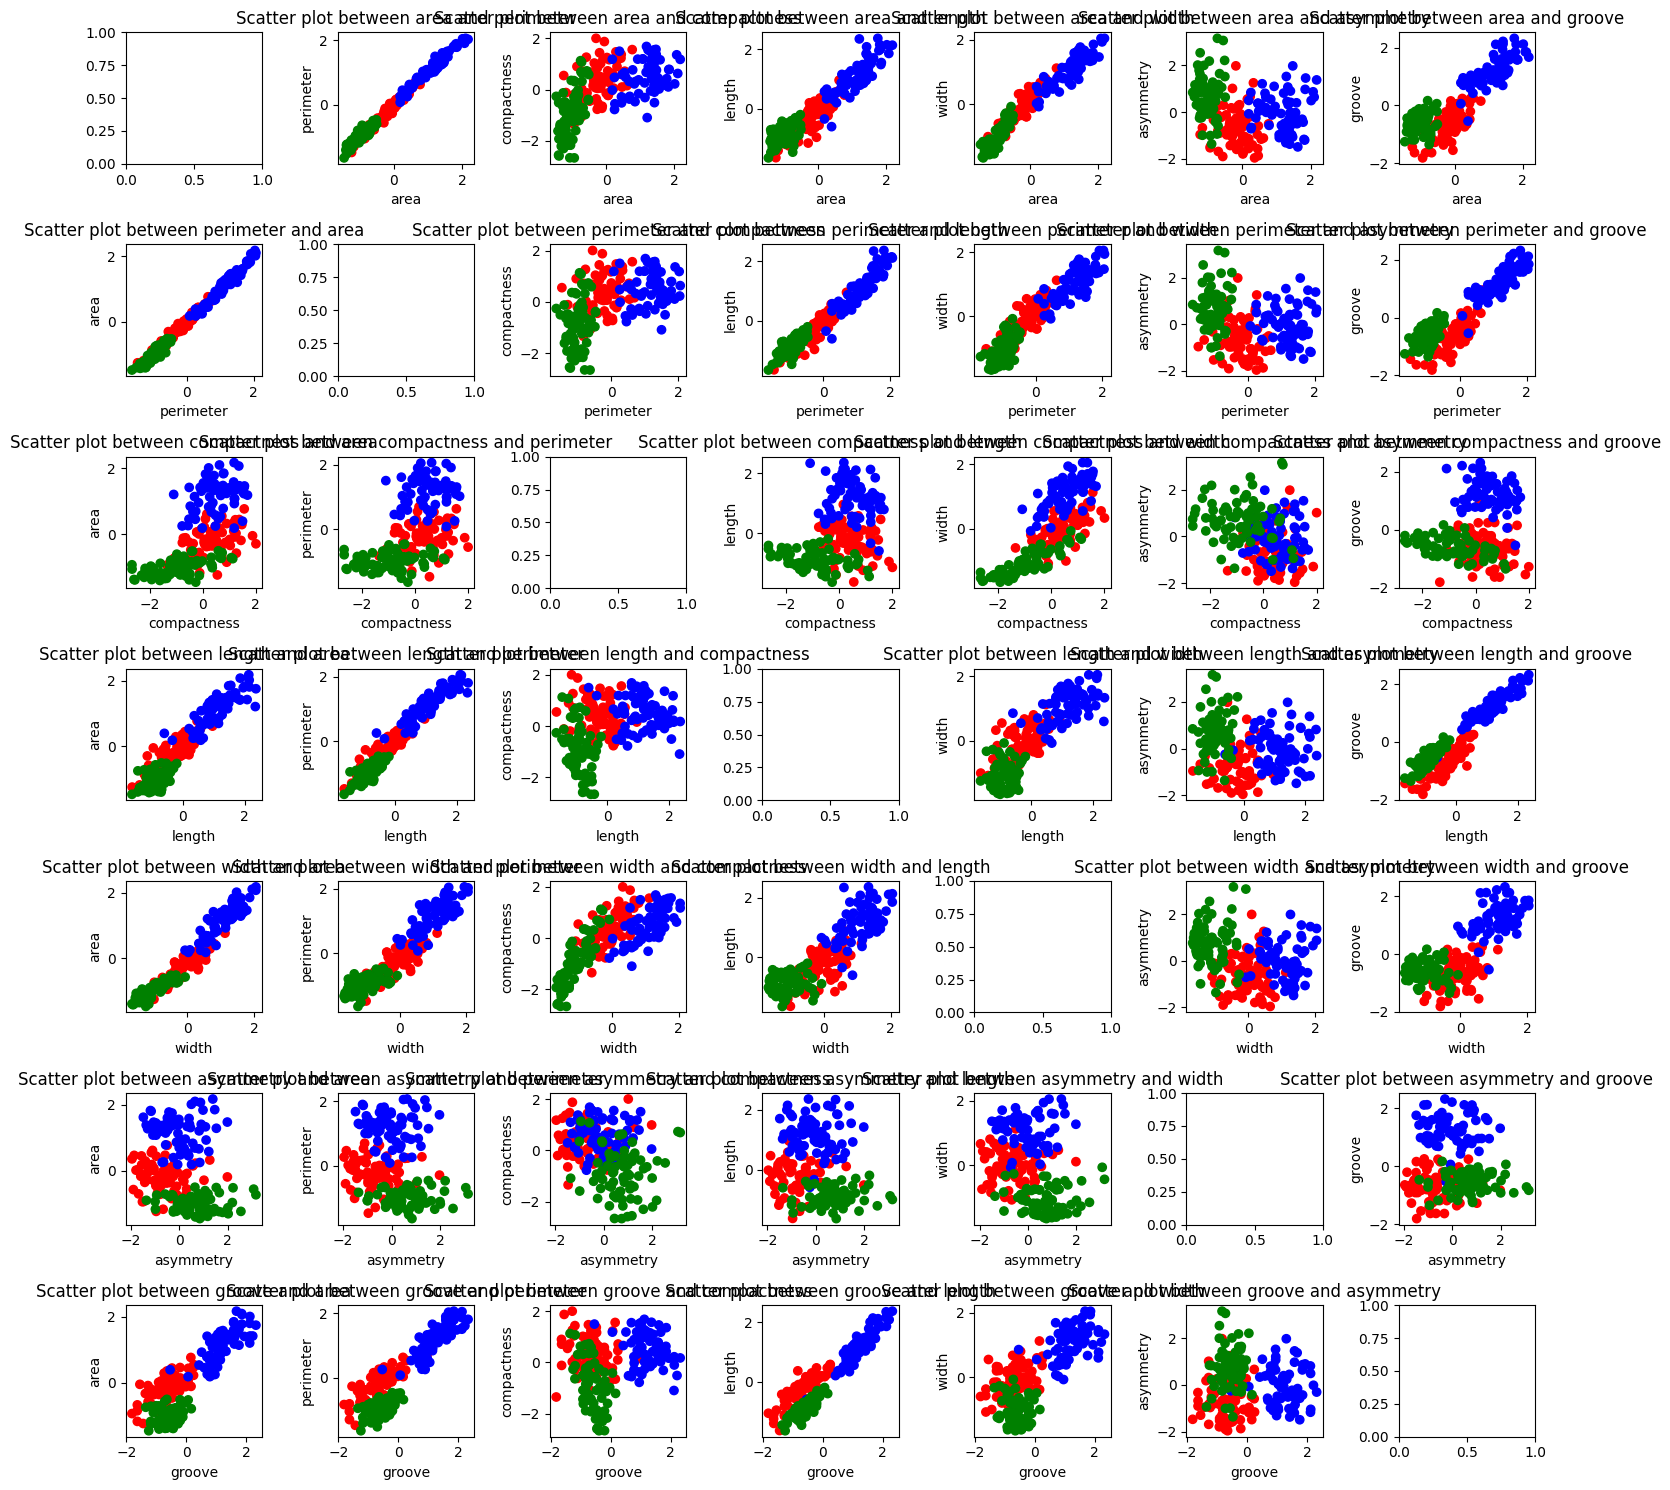

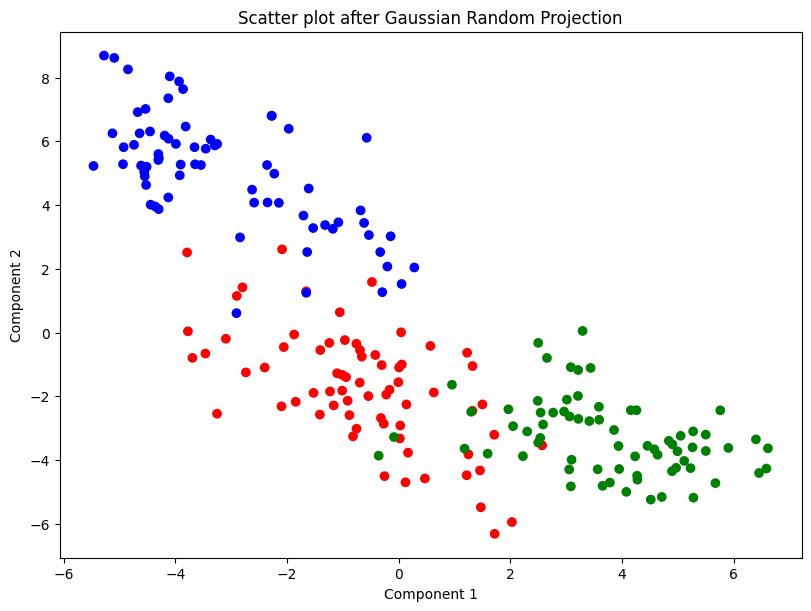

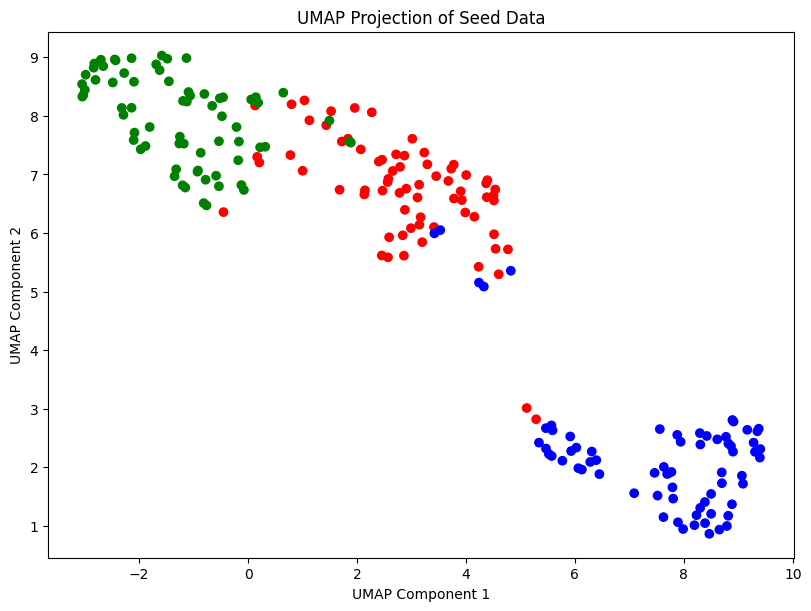

In [20]:
colors = {1: 'red', 2: 'blue', 3: 'green'}
features = seeds_normalized.columns

num_features = len(features)
num_rows = num_features - 1
num_cols = num_features - 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(num_rows):
    for j in range(num_cols):
        if i != j:
            ax = axes[i, j]
            ax.scatter(seeds_normalized[features[i]], seeds_normalized[features[j]], c=seeds_normalized['species'].map(colors))
            ax.set_xlabel(features[i])
            ax.set_ylabel(features[j])
            ax.set_title(f'Scatter plot between {features[i]} and {features[j]}')

plt.tight_layout()
plt.show()


grp = GaussianRandomProjection(n_components=2, random_state=random_state)
X_projected = grp.fit_transform(seeds_normalized.drop(columns=['species']))
fig2, ax2 = plt.subplots(figsize=(8, 6), layout='constrained')
ax2.scatter(X_projected[:, 0], X_projected[:, 1],  c=seeds_normalized['species'].map(colors))
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('Scatter plot after Gaussian Random Projection')
fig2.savefig("gaussian_random_projection.pdf", bbox_inches='tight')


umap_model = umap.UMAP(n_components=2)

X_umap = umap_model.fit_transform(seeds_normalized.drop(columns=['species']))

fig3, ax3 = plt.subplots(figsize=(8, 6), layout='constrained')
ax3.scatter(X_umap[:, 0], X_umap[:, 1], c=seeds_normalized['species'].map(colors))
ax3.set_xlabel('UMAP Component 1')
ax3.set_ylabel('UMAP Component 2')
ax3.set_title('UMAP Projection of Seed Data')
fig3.savefig("umap.pdf", bbox_inches='tight')


<h1>Evaluate clustering</h1>

In [21]:
true_labels = seeds_normalized['species']

kmeans = KMeans(n_clusters=len(true_labels.unique()), random_state=random_state)
kmeans.fit(seeds_normalized.drop(columns=['species']))

kmeans_labels = kmeans.labels_

rand_index = rand_score(true_labels, kmeans_labels)
print("Rand index:", rand_index)


unique_true_labels = true_labels.unique()
unique_kmeans_labels = pd.Series(kmeans_labels).unique()


all_labels = pd.Series(kmeans_labels)._append(true_labels)
all_unique_labels = all_labels.unique()


def find_permutation(n_clusters, true_labels, cluster_labels):
    permutations = itertools.permutations(range(n_clusters))
    best_permutation = None
    best_accuracy = 0
    for permutation in permutations:
        permuted_labels = [permutation[label] for label in cluster_labels]
        accuracy = accuracy_score(permuted_labels, true_labels)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_permutation = permutation
    return best_permutation, best_accuracy

best_permutation, best_accuracy = find_permutation(len(all_unique_labels), true_labels, kmeans_labels)

print("Best Accuracy:", best_accuracy)
print("Best Permutation:", best_permutation)


Rand index: 0.8995215311004785
Best Accuracy: 0.9186602870813397
Best Permutation: (2, 3, 1, 0)


<h1>Agglomerative clustering</h1>

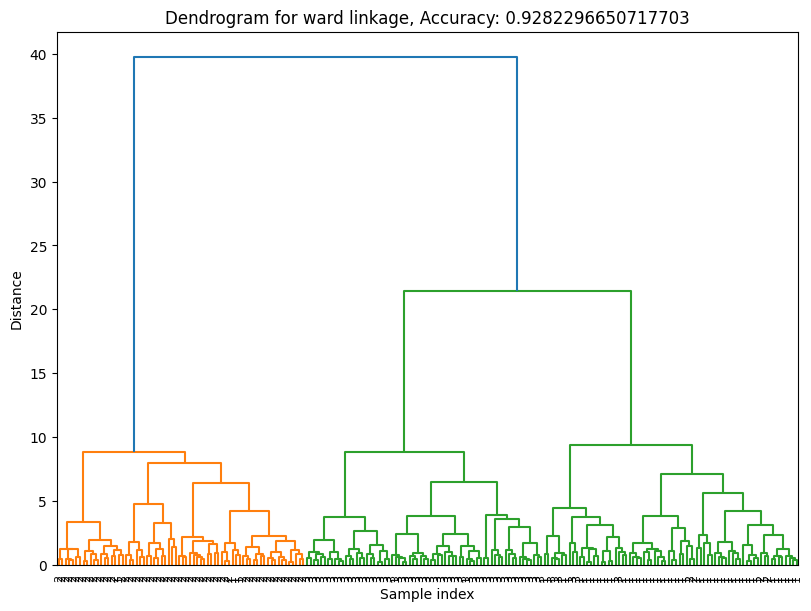

In [22]:
linkage_options = ['ward', 'complete', 'average', 'single']

best_accuracy = 0
best_linkage = None

for linkage_option in linkage_options:
    clustering = AgglomerativeClustering(n_clusters=len(unique_true_labels), linkage=linkage_option)
    cluster = clustering.fit(X_normalized)
    permutation, accuracy = find_permutation(len(all_unique_labels), true_labels, cluster.labels_)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_linkage = linkage_option

Z = linkage(X_normalized, method=best_linkage)
fig4, ax4 = plt.subplots(figsize=(8, 6), layout='constrained')
dendrogram(Z, labels=true_labels.values, leaf_rotation=90, leaf_font_size=8)
ax4.set_title(f"Dendrogram for {best_linkage} linkage, Accuracy: {best_accuracy}")
ax4.set_xlabel("Sample index")
ax4.set_ylabel("Distance")
fig4.savefig("dendrogram.pdf", bbox_inches='tight')
